I'm protyping some RL models in this notebook

Homero

## TD Models

TD-learning family models:
1. <a href='#oneStepTD'> TD(0) </a>
2. TDLambda
3. [TDLambdaSR](#TDLambdaSR)

In [1]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

import sys
module_path = 'src' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *
from plot_utils import plot_trajectory
from BaseModel import BaseModel

from plot_utils import plot_maze_stats
import parameters
from parameters import HOME_NODE, RWD_NODE, INVALID_STATE, WATER_PORT_STATE

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
def visualize_pred(avg_V, state_hist_all, save_dir=None):
    '''
    avg_V: vector of state values averaged across multiple runs of the model
           ndarray[(1,S), float]
    state_hist_all: dictionary of trajectories simulated by a model. Eg. state_hist_all{0:[0,1,3..], 1:[]..}
    
    Returns: A heatmap of state values and predicted trajectories plotted on the maze layout
    '''
    # Plotting state values
    fig, ax = plt.subplots(figsize=(10,3))
#     axhandle = ax.imshow(np.transpose(np.reshape(avg_V,(S,1))),cmap='YlGnBu')
    S = rl_model.S  # TODO: this should probably be a parameter
    plt.pcolor(np.transpose(np.reshape(avg_V,(S,1))),cmap='YlGnBu')
    plt.colorbar()
    ax.invert_yaxis()
    ax.set_ylabel('V (s)')
    ax.set_xticks(np.arange(0,127,5))
    ax.set_xticklabels([str(val) for val in np.arange(0,127,5)])
    ax.set_xlabel('Nodes')
    ax.set_title('Average state values for TD(0) with alpha: %.2f, beta: %.2f and gamma: %.2f' %(alpha,beta,gamma))
#     fig.colorbar(axhandle,fraction=0.005)

    print('Max state value ', np.max(avg_V))
    print('Min state value', np.min(avg_V))

    # Plot predicted trajectories
    plot_trajectory(state_hist_all, 'all')

In [4]:
def softmax(s, V, beta):
    '''
    Selects an action (either 0, 1 or 2) to take from current state, s using the current set of state-values and beta parameter.
    :param V: state-values for all nodes, ndarray[S, float]
    :param beta: fixed or fitted inverse temperature parameter, beta
    :return:
    '''

    if s == RWD_NODE or s == HOME_NODE:
        prob = [0,1,0]
        a = 1
    elif INVALID_STATE in nodemap[s, :]:
        prob = [1,0,0]
        a = 0  # If the current state is an end node, a = 0 will make a transition to level 5 node
    else:
        softmaxEXP = []
        next_options = nodemap[s, :]
        for node in next_options:
            softmaxEXP.extend([np.exp(beta * V[node])])
        prob = softmaxEXP / np.sum(softmaxEXP)
        try:
            a = np.random.choice([0, 1, 2], 1, p=prob)[0]
        except:
            a = INVALID_STATE
            print('Error with probabilities. softmaxEXP: ', softmaxEXP, ' nodes: ', nodemap[s, :], ' state-values: ', V[nodemap[s, :]])

    return a, prob

### TD(0) <a id='#oneStepTD'></a>
Online TD-control algorithm which estimates state values, V(s)
 - States: 128 maze nodes (including home node)
 - Terminal states: maze entry, 127 and reward port, 116
 - Rewards: 0 on all states except for 1 on the water port
 
 Pseudocode
- Softmax action selection policy: $\pi(a | s_i) = \frac{e^{\beta*V(s_{ij})}}{e^{\beta*V(s_{ij})} + e^{\beta*V(s_{ij})} + e^{\beta*V(s_{ij})}}$, where j indexes the 3 neighboring nodes to $s_i$
- State-value update: $V(s) \leftarrow V(s) + \alpha*(R + \gamma*V(s') - V(s))$

 Re-parametrized version where $\beta = \beta * \alpha$ and $V(s) = \frac{V(s)}{\alpha}$
- original action-value update: $V(s) \leftarrow (1-\alpha)V(s) + \alpha(R + \gamma * V(s'))$
- new action-value update: $V(s) \leftarrow (1-\alpha)V(s) + R + \alpha * \gamma * V(s')$

episode  0
episode  1
100th step
action  1 state  67
200th step
action  0 state  18
300th step
action  1 state  77
episode  2
episode  3
100th step
action  2 state  76
episode  4
alpha:  0.01  beta:  10  gamma:  1
Max state value  0.0
Min state value 0.0


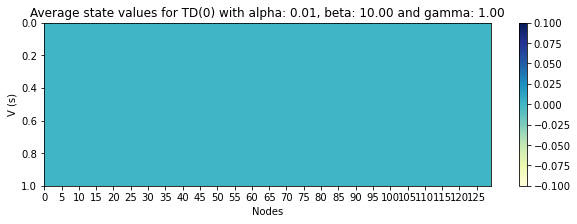

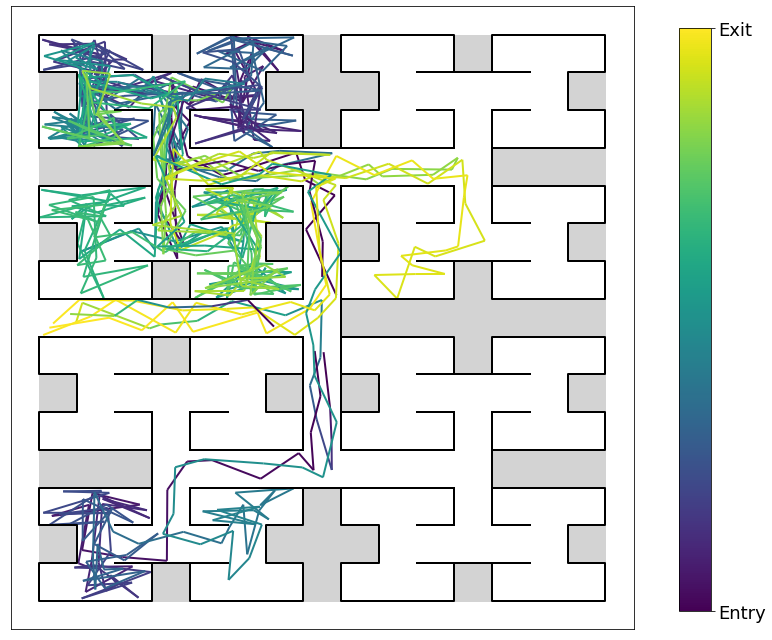

In [36]:
# Define TD(0) model
'''
Toy TD(0) model to simulate trajectories with

Returns: state_hist_all, dictionary of trajectories most recently simulated by the model. 
         If avg_count > 1, state_hist_all represents the latest simulation results
         Type: state_hist_all{0:[0,1,3..], 1:[]..}
         
         avg_V, average state-values resulting from simulation.
         Type: ndarray[(1,S), float]
'''
RewardNodeMag = 1
# np.random.seed(0)
# Set environment parameters
rl_model = BaseModel()
nodemap = rl_model.get_SAnodemap()
# nodemap = get_SAnodemap(S,A)  # rows index the current state, columns index 3 available neighboring states

# Set model parameters
alpha = 0.01  # learning rate
gamma = 1
beta = 10  # softmax exploration - exploitation
N = 5  # number of episodes to train over
speed = 10  # mice speed in nodes per sec
timeout = 10  # units of seconds that the reward port times out

# Simulation settings
avg_count = 1  # Number of times to repeat the simulation. Only state-values will be averaged, avg_V
avg_V = np.zeros(rl_model.S)


for count in np.arange(avg_count):
    # Initialize model parameters
    V = np.zeros(rl_model.S) #np.random.rand(S)  # state-action values
    V[parameters.HOME_NODE] = 0  # setting action-values of maze entry to 0
    V[parameters.RWD_NODE] = 0  # setting action-values of reward port to 0
    state_hist_all = {}
    total_reward = 0
    t = timeout

    for n in np.arange(N):
        # Initialize starting state,s0 to node 0
        s = 0
        state_hist = []
        print("episode ", n)
        
        step_count=0
        # Begin episode
        while s!=parameters.HOME_NODE and step_count<=100000: #and s!=RewardNode:
            # Record current state
            state_hist.extend([s])

            # Use softmax policy to select action, a at current state, s
            a, _ = softmax(s, V, beta)

            # Observe reward and next state based on selected action
            sprime = int(nodemap[s,a])
            if sprime == RWD_NODE and t >= timeout:
                R = RewardNodeMag  # Receive a reward of 1 when transitioning to the reward port
                total_reward += 1
                t = 0  # Reset timer
            else:
                R = 0
                t += speed  # Increment time from last reward

            # Update action-value of previous state value, V[s]
            V[s] += alpha * (R + gamma*V[sprime] - V[s])

            # Shift state values for the next time step
            s = sprime
            step_count+=1
            if step_count%100==0:
                print("%dth step" % step_count)
                print("action ", a, 'state ', s)
        if step_count>100000:
            print("didn't reach home")
        state_hist.extend([s])
        state_hist_all[n] = state_hist

    avg_V += deepcopy(V)
avg_V /= avg_count

print('alpha: ', alpha, ' beta: ', beta, ' gamma: ', gamma)
visualize_pred(avg_V, list(state_hist_all.values()))

### TD($\lambda$)

 - States: 128 maze nodes (including home node)
 - Terminal states: maze entry, 127 and reward port, 116
 - Rewards: 0 on all states except for 1 on the water port
 
 Pseudocode
- Softmax action selection policy: $\pi(a | s_i) = \frac{e^{\beta*V(s_{ij})}}{e^{\beta*V(s_{ij})} + e^{\beta*V(s_{ij})} + e^{\beta*V(s_{ij})}}$, where j indexes the 3 neighboring nodes to $s_i$
- Temporal difference error: $\delta = R + \gamma*V(s') - V(s)$
- Eligibility trace: $e(s) \leftarrow e(s) + 1$
- State-value update: $V(s) \leftarrow V(s) + \alpha*(\delta)*e(s)$        [all state-values are updated at each step]
- Eligibility trace decay: $e(s) \leftarrow \gamma*\lambda*e(s)$           [eligibility traces of all states are decayed at each step]

In [ ]:
# Define TD(lambda) model
'''
Toy TD(lambda) model to predict trajectories

Returns: state_hist_all, dictionary of trajectories most recently simulated by the model. 
         If avg_count > 1, state_hist_all represents the latest simulation results
         Type: state_hist_all{0:[0,1,3..], 1:[]..}
         
         avg_V, average state-values resulting from simulation.
         Type: ndarray[(1,S), float]
'''

# Set environment parameters
nodemap = get_SAnodemap(S,A)  # rows index the current state, columns index 3 available neighboring states

# Set model parameters
alpha = 0.1   # learning rate, 0 < alpha < 1
beta = 10      # softmax exploration - exploitation
gamma = 1      # degree of discounting future state values, 0 < gamma < 1 
lamda = 0.5    # extent of past states to update, 0 < lambda < 1
N = 10          # number of episodes to train over
#speed = 10  # mice speed in nodes per sec
#timeout = 10  # units of seconds that the reward port times out

# Simulation settings
avg_count = 1  # Number of times to repeat the simulation. Only state-values will be averaged, avg_V
avg_V = np.zeros(S)

for count in np.arange(avg_count):
    # Initialize model parameters
    V = np.zeros(S)    # state values
    V[HomeNode] = 0    # setting state-values of maze entry to 0
    V[RewardNode] = 0  # setting state-values of reward port to 0
    e = np.zeros(S)    # eligibility trace vector for all states
    state_hist_all = {}
    #t = timeout

    for n in np.arange(N):
        # Initialize starting state,s0 to node 0
        s = 0
        state_hist = []

        # Begin episode
        while s!=HomeNode and s!=RewardNode:
            # Record current state
            state_hist.extend([s])

            # Use softmax policy to select action, a at current state, s
            betaV = []
            for node in nodemap[s,:]:
                if node==InvalidState:
                    betaV.extend([0])
                else:
                    betaV.extend([np.exp(beta*V[node])])
            prob = betaV/np.sum(betaV)
            try:
                a = np.random.choice([0,1,2],1,p=prob)[0]
            except ValueError:
                print('Error with aprob')
                print('Current state: ', s, 'Potential future states: ', nodemap[s,:], ' prob: ', prob)

            # Observe reward and next state based on selected action
            sprime = nodemap[s,a]
            if sprime == RewardNode: #and t >= timeout:
                R = RewardNodeMag  # Receive a reward of 1 when transitioning to the reward port
                #t = 0  # Reset timer
            else:
                R = 0
                #t += speed  # Increment time from last reward

            # Calculate error signal for current state
            td_error = R + gamma*V[sprime] - V[s]
            e[s] += 1
            
            # Propagate value to all other states
            for node in np.arange(S):
                V[node] += alpha * td_error * e[node]
                e[node] = gamma * lamda * e[node]

            # Update future state to current state
            s = sprime
            
        state_hist.extend([s])
        state_hist_all[n] = state_hist

    avg_V += deepcopy(V)
avg_V /= avg_count

print('alpha: ', alpha, ' beta: ', beta, ' gamma: ', gamma, 'lambda: ', lamda)
visualize_pred(avg_V, state_hist_all)

## TDLambdaSR

In [26]:
import sys
module_path = 'src' 
if module_path not in sys.path:
    sys.path.append(module_path)

from TDLambdaSR_model import TDLambdaSR
from plot_utils import plot_trajectory

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [28]:
agnt = TDLambdaSR()
success, stats = agnt.simulate(0, [0.3, 3, 0.89, 0.3], max_length=2000, n_bouts_to_generate=3)

Reward reached.
Home reached.
Home reached.


In [29]:
[len(stats["episodes"][i]) for i in range(len(stats["episodes"]))]  # length of episodes

[194, 270, 2]

In [70]:
stats["episodes"][1]

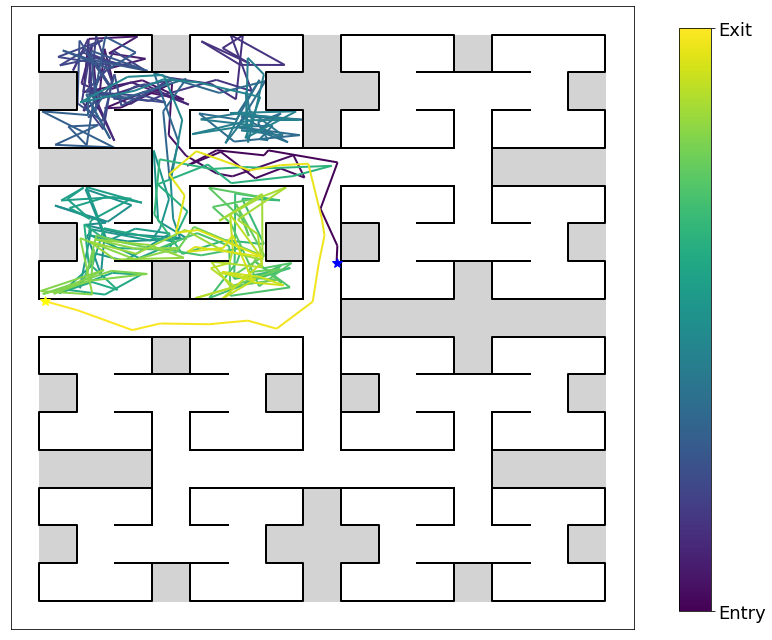

In [34]:
plot_trajectory([stats["episodes"][1]], 'all');

In [39]:
stats["V"].shape, stats["V"][129], stats["V"][128], stats["V"][127]

((130,), 0.0, 0.0, 0.0)

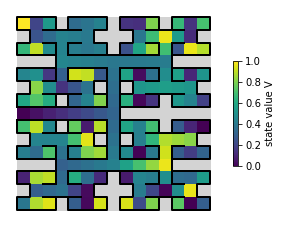

<AxesSubplot:>

In [40]:
from plot_utils import plot_maze_stats
plot_maze_stats(stats["V"], 'state_values', colormap_name=None, colorbar_label="state value V")

### Run with parallel processing (has a bug with pickle sometimes)

In [55]:
# agnt.simulate(0, [0.3, 3, 0.89, 0.3])

agnt2 = TDLambdaXStepsPrevNodeRewardReceived()
param_sets = dict([(0, [0.1, 3, 0.89, 0.7])])
# agnt2.simulate_multiple(dict([(0, [0.3, 3, 0.89, 0.3])]))
sim_results = agnt2.simulate_multiple(param_sets, MAX_LENGTH=2000)

sub_fits {0: [0.1, 3, 0.89, 0.7]}
>>> Simulating: 0 [0.1, 3, 0.89, 0.7] 2000 1
>>> module name: TDLambdaXStepsPrevNode_model parent process id: 25275 process id: 3012
alpha, beta, gamma, lamda, agentId 0.1 3 0.89 0.7 0
from_, to_ 69 34
current state 45 step 100
current state 43 step 200
current state 40 step 300
current state 40 step 400
current state 46 step 500
current state 44 step 600
current state 44 step 700
current state 44 step 800
current state 37 step 900
current state 36 step 1000
current state 40 step 1100
entering again 16640 (127, -1)
from_, to_ 31 63
current state 32 step 1200
current state 31 step 1300
entering again 16640 (127, -1)
from_, to_ 32 66
current state 36 step 1400
entering again 16640 (127, -1)
from_, to_ 32 15
current state 36 step 1500
current state 45 step 1600
current state 41 step 1700
entering again 16640 (127, -1)
from_, to_ 6 2
entering again 16640 (127, -1)
from_, to_ 8 17
current state 18 step 1800
current state 17 step 1900
Trajectory too long. Ab

In [39]:
agnt2.h

Todo:
* Create my own class of an agent with just the regular 128 states (TDLambdaXStepsPrevNodeRewardReceived includes the current and the previous node in the state representation). I will probably need to check other implementations of `generate_episode`
* implement SR
  - Calculate matrix M using $M=(I-\gamma T)^{-1}$
  - Calculate Value using V = M*R
  - plot Values at multiple times during the episode

In [4]:
from TDLambdaSR_model import TDLambdaSR

agnt = TDLambdaSR()

In [21]:
len(agnt.nodemap)

129

In [24]:
agnt.nodemap[116], \
np.logical_and(agnt.nodemap[116]!=INVALID_STATE, agnt.nodemap[116]!=WATER_PORT_STATE, array([True, True, False]))

(array([ 57, 128,  -1]), array([ True, False, False]))

In [95]:
agnt.nodemap[127]

array([-1,  0, -1])

In [57]:
agnt.nodemap[51][agnt.nodemap[51]!=INVALID_STATE]

array([ 25, 103, 104])

In [63]:
sum(agnt.nodemap[60]!=INVALID_STATE)

3

In [103]:
state=116
agnt.nodemap[state], np.logical_and(np.logical_and(agnt.nodemap[state]!=INVALID_STATE, agnt.nodemap[state]!=WATER_PORT_STATE), agnt.nodemap[state]!=HOME_NODE)

(array([ 57, 128,  -1]), array([ True, False, False]))

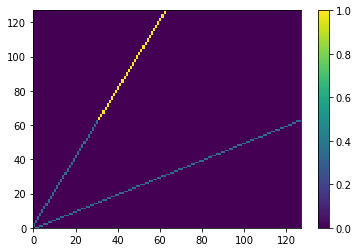

In [5]:
# %matplotlib qt
%matplotlib inline

n_states=127
T = np.zeros((n_states, n_states))
for state in arange(n_states):
    mask_valid_next_states = np.logical_and(np.logical_and(agnt.nodemap[state]!=INVALID_STATE, \
                                                           agnt.nodemap[state]!=WATER_PORT_STATE), \
                                            agnt.nodemap[state]!=HOME_NODE)
    n_possibilities = float(sum(mask_valid_next_states))
    
    for next_state in agnt.nodemap[state][mask_valid_next_states]:
        T[state, next_state] = float(1/n_possibilities)
figure()
pcolormesh(T)
colorbar()

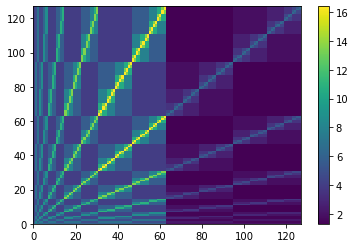

In [41]:
gamma = 0.998
M = np.linalg.inv(np.eye(n_states)-gamma*T)

figure()
pcolormesh(M)
colorbar()

In [48]:
pad(r, 1)

array([0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       1. , 0. , 0. , 0. ])

None None


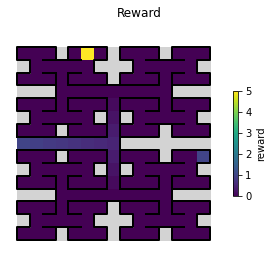

<AxesSubplot:>

In [43]:
r = np.zeros(n_states+1)
r[RWD_NODE]=1
r[0]=.5
r[127]=1

plot_maze_stats(r, 'state_values', colormap_name=None, colorbar_label="reward", figtitle="Reward")

# values = M@r[:-1]
# print(values.shape)

# bigger=zeros(128)
# bigger[:-1]=values

# plot_maze_stats(bigger, 'state_values', colormap_name=None, colorbar_label="state value V", figtitle="Values");